In [1]:
using Flux,CUDA,Transformers,Transformers.Basic,CSV,DataFrames,Plots,LinearAlgebra


In [2]:
function encoder_forward(x)
    x = encoder_input_layer(x)
    e = positional_encoding_layer(x)
    t1 = x .+ e
    t1 = dropout_pos_enc(t1)
    t1 = encode_t1(t1)
    t1 = encode_t2(t1)
    return t1
end

function decoder_forward(tgt,t1)
   decoder_output =decoder_input_layer(tgt)
   t2 = decode_t1(decoder_output,t1)
   t2 = decode_t2(decoder_output,t2)
   t2=Flux.flatten(t2)
   p = linear(t2)
   return p
end

function loss(src, trg, trg_y)
    enc = encoder_forward(src)
    dec = decoder_forward(trg, enc)
    err = Flux.Losses.mse(dec,trg_y)
    return err
end

loss (generic function with 1 method)

In [13]:
encoder_input_layer = Dense(1,512) 
decoder_input_layer = Dense(1,512)
encode_t1 = Transformer(512, 8, 64, 2048) 
encode_t2 = Transformer(512, 8, 64, 2048) 
decode_t1 = TransformerDecoder(512, 8, 64, 2048) 
decode_t2 = TransformerDecoder(512, 8, 64, 2048) 
positional_encoding_layer = PositionEmbedding(512)
linear = Dense(512,1) 
p = 0.2
dropout_pos_enc = Dropout(p)

Dropout(0.2)

In [4]:
begin
    data=CSV.read("w2021-1.csv",DataFrame,header=6)
    data0=CSV.read("w2022.csv",DataFrame,header=6)
    data1=CSV.read("w2020.csv",DataFrame,header=6)
    dataset2021=Array(transpose(Matrix{Float32}(data[1:365,[5]])))
    dataset2022=Array(transpose(Matrix{Float32}(data0[1:354,[4]])))
    dataset2020=Array(transpose(Matrix{Float32}(data1[1:365,[4]])))
    end

1×365 Matrix{Float32}:
 10.2  11.3  12.0  12.2  10.2  12.2  …  14.0  11.8  12.7  13.5  13.1  12.3

In [6]:
x1=Array(transpose(dataset2021[1:364]))
y1=Array(transpose(dataset2021[2:365]))

1×364 Matrix{Float32}:
 10.8  8.4  11.4  10.0  6.8  12.7  …  14.1  7.6  8.1  9.5  8.9  14.5  6.0

In [4]:
begin
    data=CSV.read("w2021-1.csv",DataFrame,header=6)
    data0=CSV.read("w2022-1.csv",DataFrame,header=6)
    data1=CSV.read("w2020.csv",DataFrame,header=6)
    dataset2021=Array(transpose(Matrix{Float32}(data[1:365,[5]])))
    dataset2022=Array(transpose(Matrix{Float32}(data0[1:365,[5]])))
    dataset2020=Array(transpose(Matrix{Float32}(data1[1:365,[4]])))
    x0=Array(transpose(dataset2020[1:364]))
    y0=Array(transpose(dataset2020[2:365]))
    x1=Array(transpose(dataset2021[1:364]))
    y1=Array(transpose(dataset2021[2:365]))
    x2=Array(transpose(dataset2022[1:364]))
    y2=Array(transpose(dataset2022[2:365]))
end

1×364 Matrix{Float32}:
 7.9  10.5  12.4  8.7  2.6  8.4  9.5  …  11.4  12.3  11.9  13.7  11.8  10.5

In [5]:
ps = Flux.params(encoder_input_layer, positional_encoding_layer, encode_t1, encode_t2, decoder_input_layer, decode_t1,decode_t2,  linear)
opt = ADAM(1e-4)
for i =1:1000
     grad = gradient(()->loss(x1, x1, y1), ps)
     Flux.update!(opt, ps, grad)
end

In [6]:
enc = encoder_forward(x1)
dec = decoder_forward(x1, enc)


1×364 Matrix{Float32}:
 9.2892  9.30307  10.1333  10.2626  …  11.8231  11.9835  11.8969  15.3112

In [9]:
Float64(sum((dec.-y1).^2)/length(dec)),Float64(sum(dec.*y1)/(norm(dec)*norm(y1)))

(9.941707611083984, 0.9919296503067017)

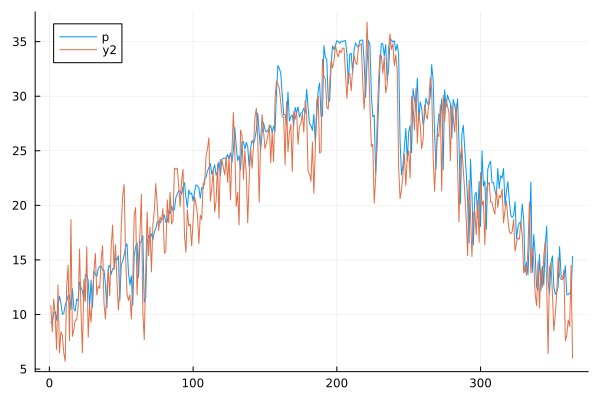

In [7]:
plot(transpose(dec),label='p')
plot!(transpose(y1))

In [10]:
enc = encoder_forward(x2)
dec = decoder_forward(x2, enc)

1×364 Matrix{Float32}:
 9.15215  9.15199  10.0063  11.2312  …  13.4408  13.0708  15.3221  13.0086

In [11]:
Float64(sum((dec.-y2).^2)/length(dec)),Float64(sum(dec.*y2)/(norm(dec)*norm(y2)))

(21.97441864013672, 0.9866981506347656)

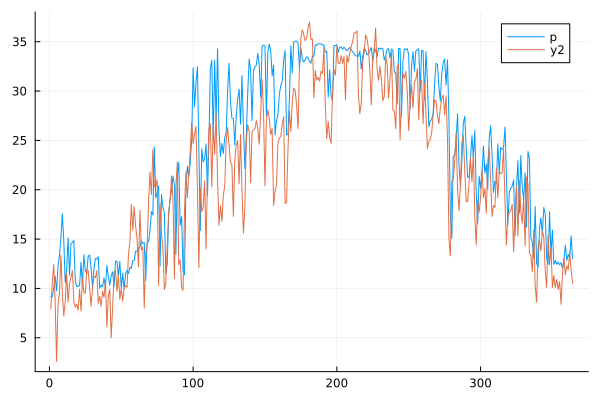

In [12]:
plot(transpose(dec),label='p')
plot!(transpose(y2))

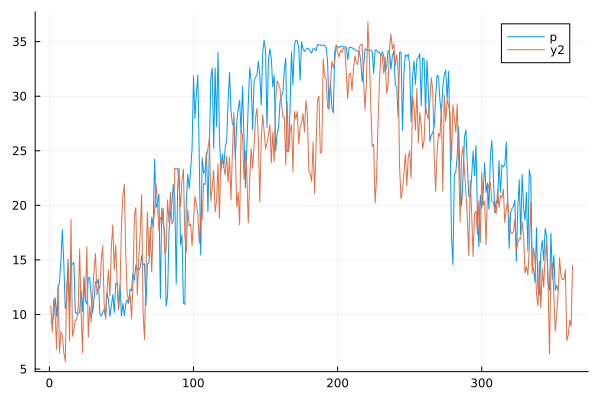

In [46]:
x11=Array(transpose(dataset2022[1:353]))
y11=Array(transpose(dataset2021[2:364]))
enc = encoder_forward(x11)
dec = decoder_forward(x11, enc)
plot(transpose(dec),label='p')
plot!(transpose(y11))


In [14]:
ps = Flux.params(encoder_input_layer, positional_encoding_layer, encode_t1, encode_t2, decoder_input_layer, decode_t1,decode_t2,  linear)
opt = ADAM(1e-4)
for i =1:1000
     grad = gradient(()->loss(dataset2020, dataset2020, dataset2021), ps)
     Flux.update!(opt, ps, grad)
end


In [22]:
enc = encoder_forward(dataset2020)
dec = decoder_forward(dataset2020, enc)

1×365 Matrix{Float32}:
 9.74543  9.8519  9.92424  9.92898  …  12.3642  12.8591  12.4704  11.9826

In [23]:
Float64(sum((dec.-dataset2021).^2)/length(dec)),Float64(sum(dec.*dataset2021)/(norm(dec)*norm(dataset2021)))

(13.968463897705078, 0.9885773062705994)

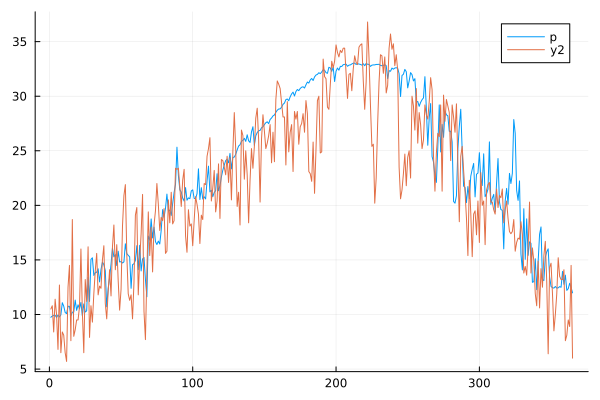

In [24]:
plot(transpose(dec),label='p')
plot!(transpose(dataset2021))

In [25]:
enc = encoder_forward(dataset2021)
dec = decoder_forward(dataset2021, enc)

1×365 Matrix{Float32}:
 9.75075  9.7663  9.6701  10.05  …  12.8627  12.6039  17.4438  13.097

In [26]:
Float64(sum((dec.-dataset2022).^2)/length(dec)),Float64(sum(dec.*dataset2022)/(norm(dec)*norm(dataset2022)))

(27.21100616455078, 0.9812406301498413)

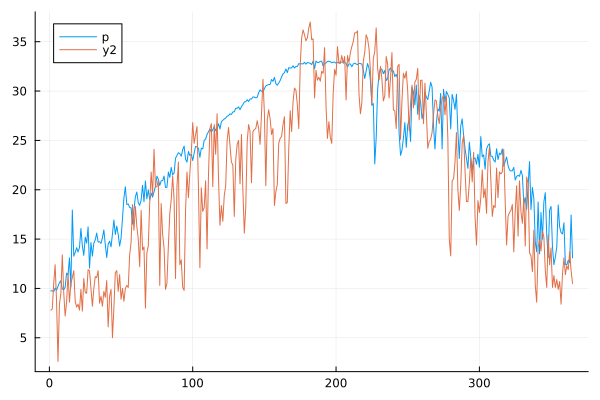

In [27]:
plot(transpose(dec),label='p')
plot!(transpose(dataset2022))

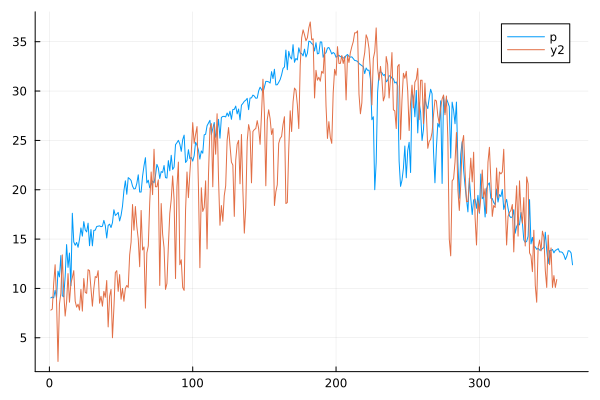

In [51]:
train_loader = Flux.Data.DataLoader([dataset2020,dataset2021], batchsize=2)
ps = Flux.params(encoder_input_layer, positional_encoding_layer, encode_t1, encode_t2, decoder_input_layer, decode_t1,decode_t2,  linear)
opt = ADAM(1e-4)
for i =1:1000
    for xi in train_loader
      x1=xi[1]
      y1=xi[2]
      grad = gradient(()->loss(x1, x1, y1), ps)
      Flux.update!(opt, ps, grad)
    end
end

enc = encoder_forward(dataset2021)
dec = decoder_forward(dataset2021, enc)

plot(transpose(dec),label='p')
plot!(transpose(dataset2022))


In [ ]:
encoder_input_layer = Dense(1,512) 
decoder_input_layer = Dense(1,512)
encode_t1 = Transformer(512, 8, 64, 2048) 
encode_t2 = Transformer(512, 8, 64, 2048) 
decode_t1 = TransformerDecoder(512, 8, 64, 2048) 
decode_t2 = TransformerDecoder(512, 8, 64, 2048) 
positional_encoding_layer = PositionEmbedding(512)
linear = Dense(512,1) 
p = 0.2
dropout_pos_enc = Dropout(p)

ps = Flux.params(encoder_input_layer, positional_encoding_layer, encode_t1, encode_t2, decoder_input_layer, decode_t1,decode_t2,  linear)
opt = ADAM(1e-4)


begin
    p,re = Flux.destructure(encoder_input_layer, positional_encoding_layer, encode_t1, encode_t2, decoder_input_layer, decode_t1,decode_t2,  linear) # use this p as the initial condition!
    dudt(u,p,t) = re(p)(u) 
    u0=[dataset2020[1]]
    prob = ODEProblem(dudt,u0,tspan)
    function loss(x)
        pred=Array(solve(prob,Tsit5(),u0=u0,p=p,saveat=1))
        l=sum(abs2,(pred[2:365].-x[2:365]))
    end

    for i =1:1000
        grad = gradient(()->loss(dataset2020), Flux.params(u0,p))
        Flux.update!(opt, Flux.params(u0,p), grad)
    end

    sol1=solve(prob,Tsit5(),u0=u0,p=Flux.params(u0,p)[2],saveat=1)
    plot(sol1)
    plot!(transpose(dataset2020))
end

In [ ]:
prob = ODEProblem(dudt,u0,tspan)